In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset

c:\Users\Manush\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# IMDb is movie review database 
dataset = load_dataset("imdb")

train_data = dataset["train"].select(range(100))

In [3]:
class EmoDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.tokenizer = tokenizer
        self.texts = data["text"]  # Assuming the IMDb dataset has 'text' as the review text
        self.labels = data["label"]  # Assuming the IMDb dataset has 'label' as the sentiment label


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text using the tokenizer
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        
        # Return tokenized input and attention mask along with the label
        return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0), torch.tensor(label)


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset and DataLoader
dataset = EmoDataset(train_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train for 10 epochs
losses = []
model.train()
for i in range(10):
    epoch_loss = 0
    for inputs, masks, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(input_ids=inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  
    avg_loss = epoch_loss / len(dataloader)  
    losses.append(avg_loss)
    print(f"Epoch {i} -> Loss: {avg_loss:.4f}")




Epoch 0 -> Loss: 0.1173
Epoch 1 -> Loss: 0.0133
Epoch 2 -> Loss: 0.0053
Epoch 3 -> Loss: 0.0030
Epoch 4 -> Loss: 0.0019
Epoch 5 -> Loss: 0.0014
Epoch 6 -> Loss: 0.0011
Epoch 7 -> Loss: 0.0008
Epoch 8 -> Loss: 0.0007
Epoch 9 -> Loss: 0.0006
Predicted label: 0


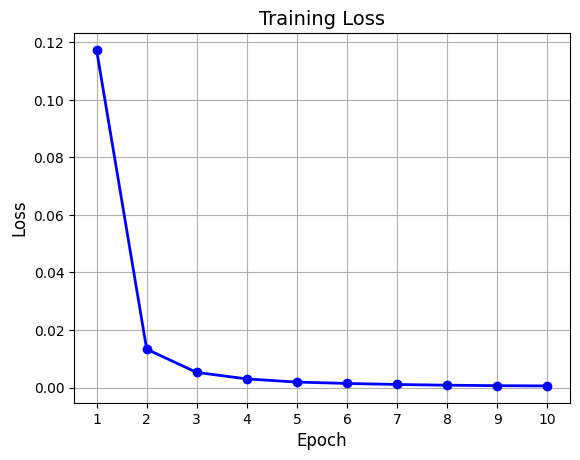

In [21]:
plt.plot(range(1, 11), losses, marker='o', linestyle='-', color='b', markersize=6, linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss", fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  
plt.show()

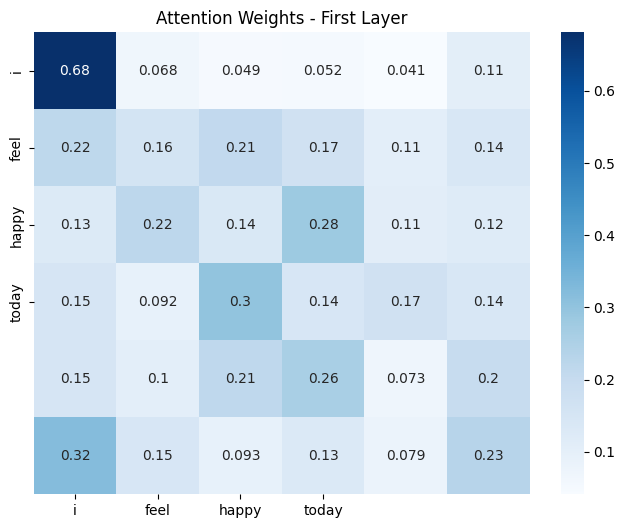

In [28]:
model.eval()
text = "I feel happy today"
encoding = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    outputs = model(**encoding, output_attentions=True)

# Visualize attention for first attention layer 
attentions_first_layer = outputs.attentions[0].squeeze(0).mean(dim=0).cpu().numpy()
tokenized_text = tokenizer.tokenize(text)

plt.figure(figsize=(8, 6))
sns.heatmap(attentions_first_layer, xticklabels=tokenized_text, yticklabels=tokenized_text, cmap="Blues", annot=True)
plt.title("Attention Weights - First Layer")
plt.show()


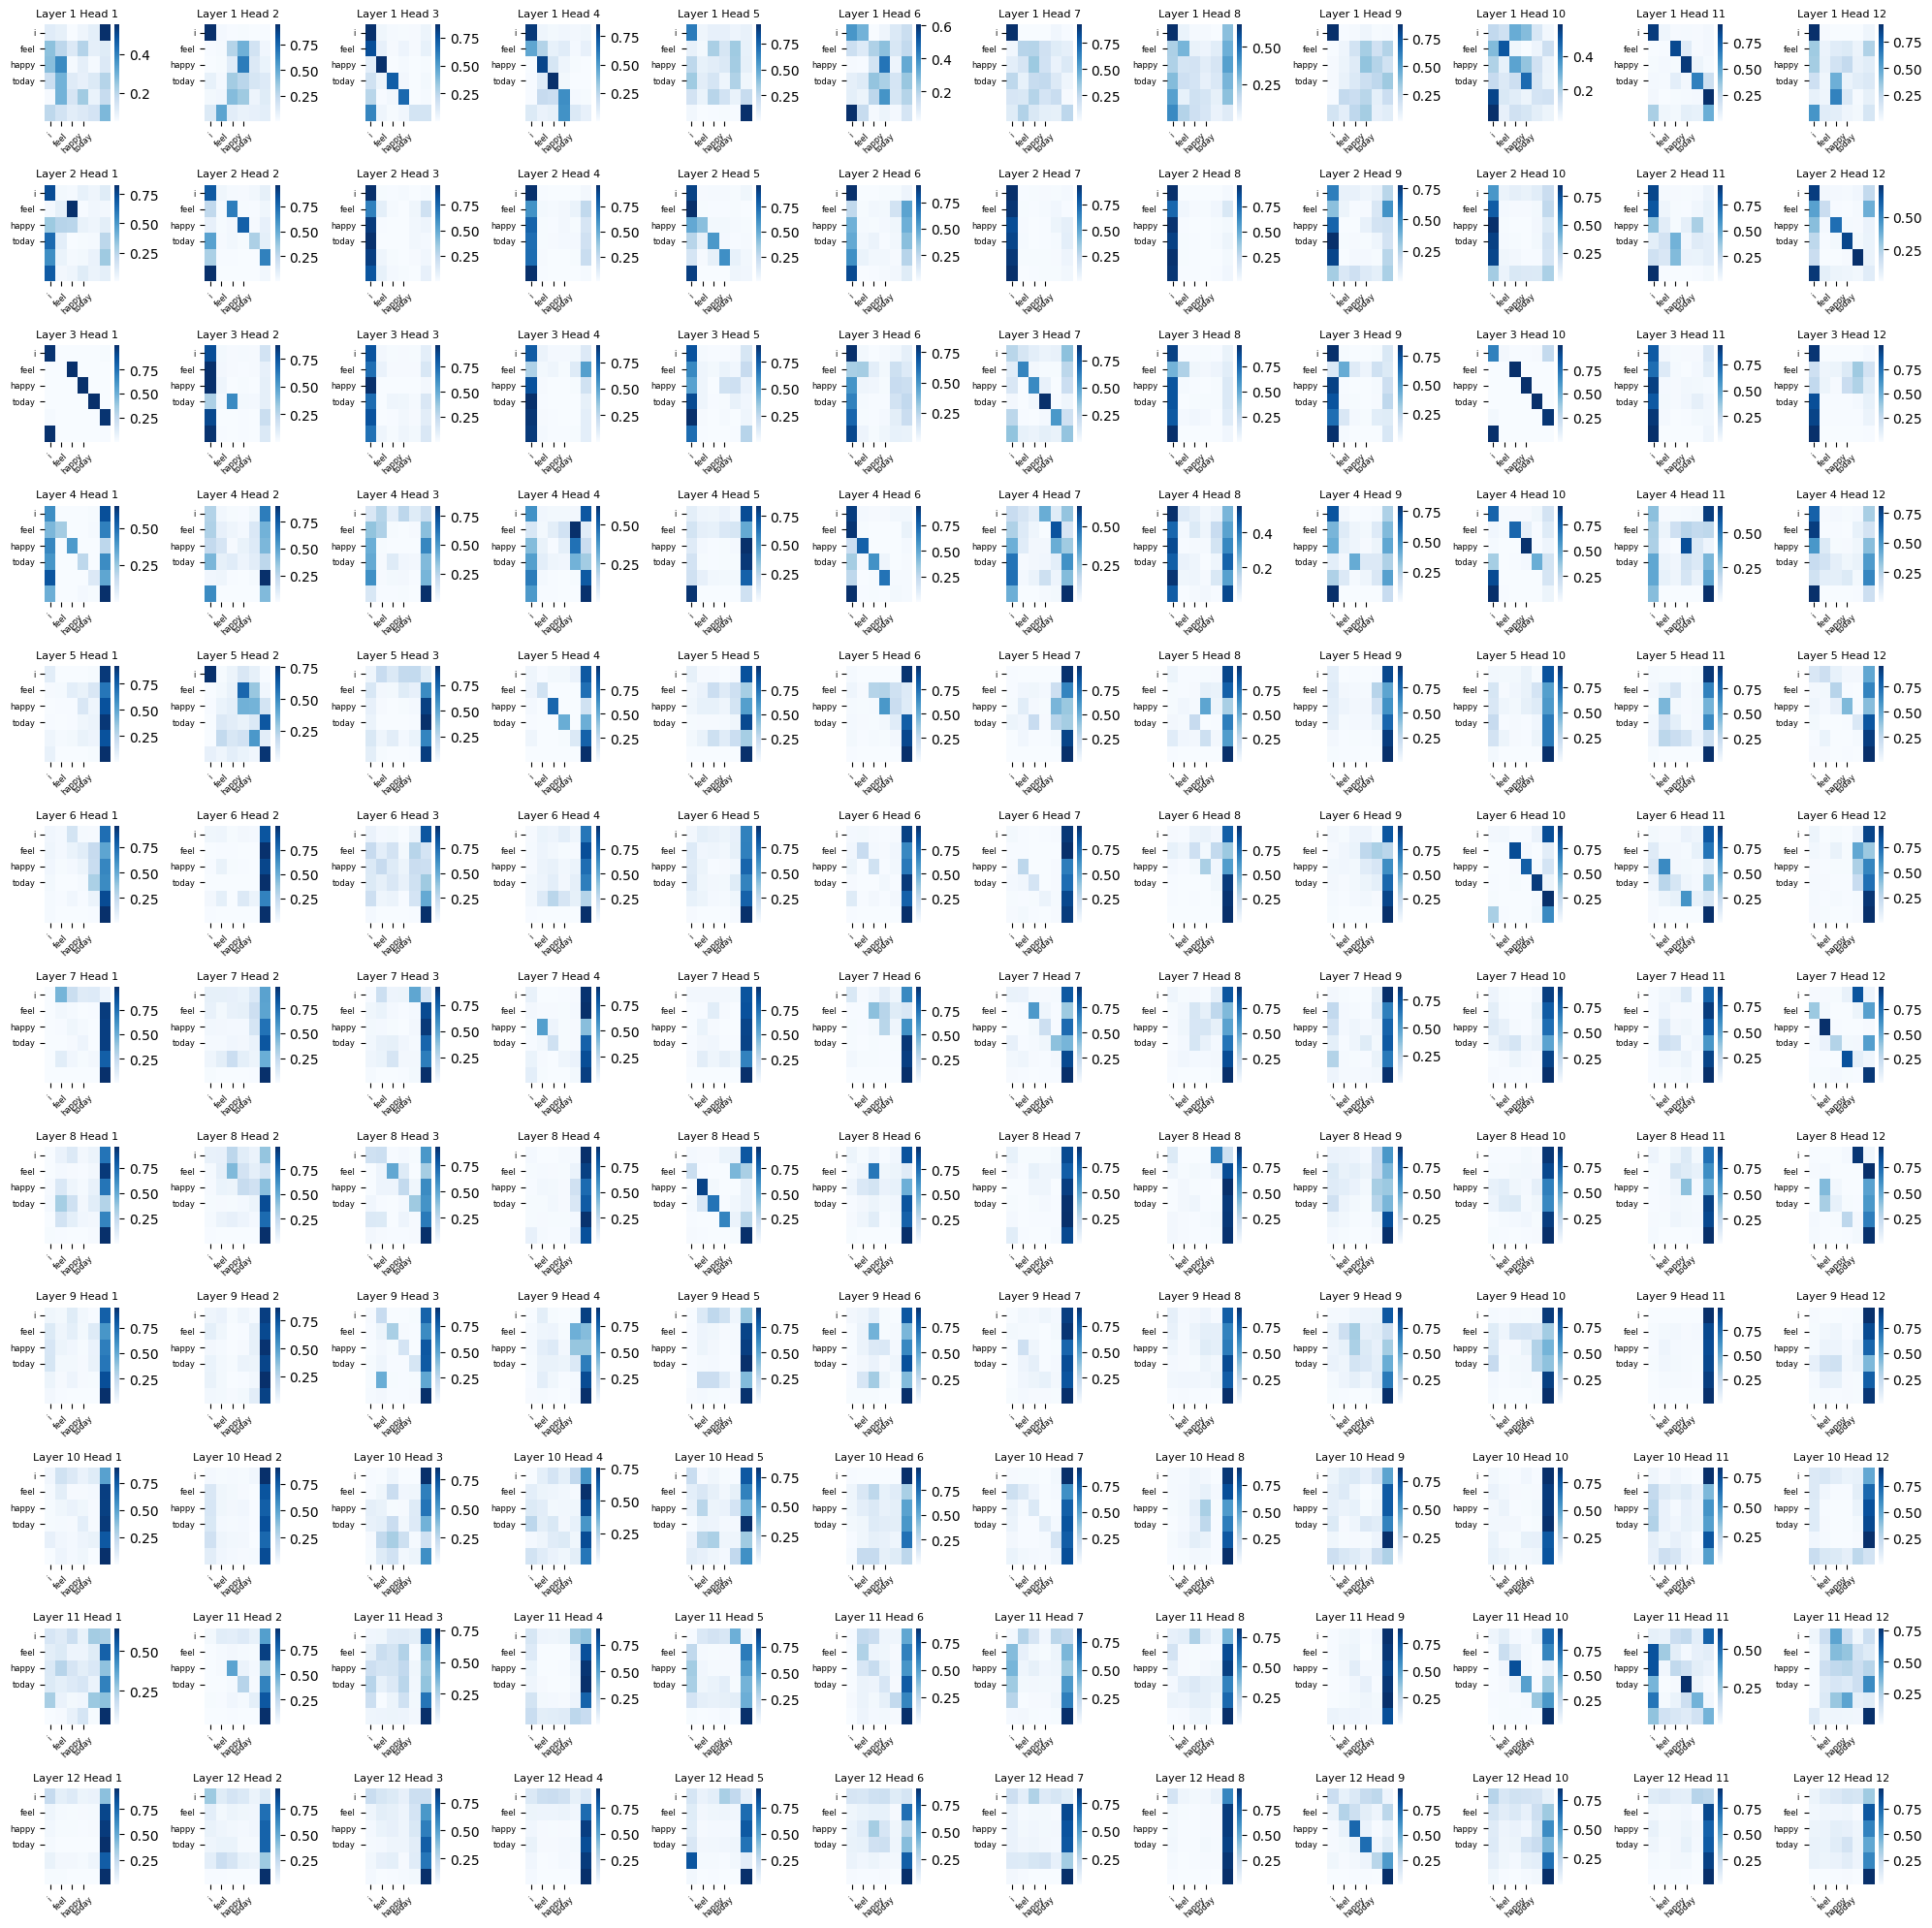

In [ ]:
# we can visualize all 12 heads of all 12 layers
num_layers = 12
num_heads = 12

fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 20))

for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        
         # we extract and plot each head's attention 
        attention_matrix = outputs.attentions[layer_idx].squeeze(0)[head_idx].cpu().numpy()
        
        ax = axes[layer_idx, head_idx]
        sns.heatmap(attention_matrix, xticklabels=tokenized_text, yticklabels=tokenized_text, cmap="Blues", annot=False, ax=ax)
        ax.set_title(f"Layer {layer_idx + 1} Head {head_idx + 1}", fontsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

plt.tight_layout()  
plt.show()